wImporting libraries

In [21]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt  # added for plotting
import numpy as np  # added for y-axis tick steps

Loading test data

In [22]:
dirty_flag = False
dirty = 'dirty/' if dirty_flag else ''

send_acks_05_08_df = pd.read_csv(f'data/05.08.25/send_rx.csv', sep=';')
recv_05_08_df = pd.read_csv(f'data/05.08.25/recv_rx.csv', sep=';')
send_05_08_df = pd.read_csv(f'data/05.08.25/send_tx.csv', sep=';')

send_acks_07_08_df = pd.read_csv(f'data/07.08.25/{dirty}send_rx.csv', sep=';')
recv_07_08_df = pd.read_csv(f'data/07.08.25/{dirty}recv_rx.csv', sep=';')
send_07_08_df = pd.read_csv(f'data/07.08.25/{dirty}send_tx.csv', sep=';')

send_acks_20_08_df = pd.read_csv(f'data/20.08.25/{dirty}send_rx.csv', sep=';')
recv_20_08_df = pd.read_csv(f'data/20.08.25/{dirty}recv_rx.csv', sep=';')
send_20_08_df = pd.read_csv(f'data/20.08.25/{dirty}send_tx.csv', sep=';')

send_acks_21_08_df = pd.read_csv(f'data/21.08.25/{dirty}send_rx.csv', sep=';')
recv_21_08_df = pd.read_csv(f'data/21.08.25/{dirty}recv_rx.csv', sep=';')
send_21_08_df = pd.read_csv(f'data/21.08.25/{dirty}send_tx.csv', sep=';')

send_acks_22_08_df = pd.read_csv(f'data/22.08.25/{dirty}send_rx.csv', sep=';')
recv_22_08_df = pd.read_csv(f'data/22.08.25/{dirty}recv_rx.csv', sep=';')
send_22_08_df = pd.read_csv(f'data/22.08.25/{dirty}send_tx.csv', sep=';')

dataset_send = [send_05_08_df, send_07_08_df, send_20_08_df, send_21_08_df, send_22_08_df]
dataset_acks = [send_acks_05_08_df, send_acks_07_08_df, send_acks_20_08_df, send_acks_21_08_df, send_acks_22_08_df]
dataset_recv = [recv_05_08_df, recv_07_08_df, recv_20_08_df, recv_21_08_df, recv_22_08_df]
dataset_i = [0, 1, 2, 3, 4]

used_ds_send = []
used_ds_acks = []
used_ds_recv = []
for i in dataset_i:
    used_ds_send.append(dataset_send[i])
    used_ds_acks.append(dataset_acks[i])
    used_ds_recv.append(dataset_recv[i])

send_df = pd.concat(used_ds_send, ignore_index=True)
send_acks_df = pd.concat(used_ds_acks, ignore_index=True)
recv_df = pd.concat(used_ds_recv, ignore_index=True)

# Convert timestamp columns to datetime objects
send_df['Timestamp'] = pd.to_datetime(send_df['Timestamp'])
send_acks_df['Timestamp'] = pd.to_datetime(send_acks_df['Timestamp'])
send_acks_df['Power'] = send_acks_df['Power'].astype('int32')
send_acks_df['RSSI'] = send_acks_df['RSSI'].astype('int32')
recv_df['Timestamp'] = pd.to_datetime(recv_df['Timestamp'])
recv_df['Power'] = recv_df['Power'].astype('int32')
recv_df['RSSI'] = recv_df['RSSI'].astype('int32')

Sorting by timestamp

In [23]:
# Sort dataframes by timestamp
send_df = send_df.sort_values(by='Timestamp').reset_index(drop=True)
send_acks_df = send_acks_df.sort_values(by='Timestamp').reset_index(drop=True)
recv_df = recv_df.sort_values(by='Timestamp').reset_index(drop=True)

Helper functions

In [24]:
def split_batches(df, gap_seconds=60):
    df = df.sort_values('Timestamp').reset_index(drop=True)
    time_diff = df['Timestamp'].diff().dt.total_seconds().fillna(0)
    batch_breaks = time_diff > gap_seconds
    batch_ids = batch_breaks.cumsum()
    batches = [batch for _, batch in df.groupby(batch_ids)]
    return batches

def get_next_batch(batches, timestamp, max_delay_seconds=60):
    for batch in batches:
        first_ts = batch.iloc[0]['Timestamp']
        if pd.Timedelta(0) <= (first_ts - timestamp) <= pd.Timedelta(seconds=max_delay_seconds):
            return batch
    return None

def get_limited_batch(from_tsmp, to_tsmp, df):
    return df[(df['Timestamp'] >= from_tsmp) & (df['Timestamp'] <= to_tsmp)]

In [25]:
total = len(send_df)
print('Total number of messages sent:', total)

sizes = send_df['Msg Size'].unique()
print('Packet sizes:', sizes)

Total number of messages sent: 1985
Packet sizes: [  7  16  26  56 106]


In [26]:
normalize_rcv_ack = True
# Collect records for plotting (one row per batch with ACK data)
ack_per_distance_records = []

for sz in sizes:
    # recv_by_sz = recv_df[recv_df['Msg Size'] == sz]
    send_by_sz = send_df[send_df['Msg Size'] == sz]

    send_batches = split_batches(send_by_sz)
    # recv_batches = split_batches(recv_by_sz)
    print("Size: ", sz)
    print("Number of send_batches: ", len(send_batches))
    print()

    batch_len = 20
    for i, batch in enumerate(send_batches):
        if len(batch) != batch_len:
            print("Warning: Batch length is not equal to expected length:", len(batch), "!= ", batch_len)

        print("Batch", len(batch), " from: ", batch.iloc[0]['Timestamp'], " to ", batch.iloc[-1]['Timestamp'])

        rtt = 10
        recv_batch = get_limited_batch(batch.iloc[0]['Timestamp'] - timedelta(seconds=1), batch.iloc[-1]['Timestamp'] + timedelta(seconds=rtt), recv_df)

        if recv_batch is not None:
            recv_per = len(recv_batch) / len(batch)
            print('PER', i, ': ', recv_per)

            recv_power = recv_batch[(recv_batch['Power'] < 100.0)]['Power'].mean()
            recv_rssi = recv_batch[recv_batch['RSSI'] < 100.0]['RSSI'].mean()
        else:
            recv_per = None
            print('PER', i, ': No matching batch found')

        wait_for_ack = 6
        ack_batch = get_limited_batch(batch.iloc[0]['Timestamp'], batch.iloc[-1]['Timestamp'] + timedelta(seconds=wait_for_ack), send_acks_df)
        if ack_batch is not None and not ack_batch.empty:
            distance = ack_batch['Avg Distance, m'].mean()
            per = len(ack_batch) / len(batch)
            if distance > 500:
                print('Warning: Distance seems too large', distance)
                print()
                continue
            print('ACK PER', i, ': ', per)
            print('Avg Distance: ', distance)
            if pd.notna(distance):
                if recv_per < per:
                    print('Warning: receive per is smaller than ack per')
                    if normalize_rcv_ack:
                        print('Equalizing receive per to ack per')
                        recv_per = per
                ack_per_distance_records.append({
                    'Msg Size': sz,
                    'Distance': distance // 10 * 10,
                    'PER': per,
                    'Recv_PER': recv_per,
                    'Power': recv_power,
                    'RSSI': recv_rssi
                })
        else:
            print('ACK PER', i, ': No matching batch found')
        print()

    print()

Size:  7
Number of send_batches:  22

Batch 20  from:  2025-08-05 16:19:07.568000  to  2025-08-05 16:19:21.615000
PER 0 :  1.0
ACK PER 0 :  1.0
Avg Distance:  10.0

Batch 40  from:  2025-08-07 16:06:03.662000  to  2025-08-07 16:09:39.104000
PER 1 :  0.025
ACK PER 1 :  0.925
Avg Distance:  34.7
Equalizing receive per to ack per

Batch 20  from:  2025-08-07 16:36:16.158000  to  2025-08-07 16:37:46.166000
PER 2 :  0.0
ACK PER 2 :  0.65
Avg Distance:  66.68153846153847
Equalizing receive per to ack per

Batch 20  from:  2025-08-07 16:41:39.031000  to  2025-08-07 16:43:13.038000
PER 3 :  0.45
ACK PER 3 :  0.6
Avg Distance:  66.715
Equalizing receive per to ack per

Batch 25  from:  2025-08-07 16:55:34.213000  to  2025-08-07 16:57:48.223000
PER 4 :  0.0
ACK PER 4 : No matching batch found

Batch 20  from:  2025-08-07 16:59:03.775000  to  2025-08-07 17:00:21.770000
PER 5 :  1.0
ACK PER 5 :  1.0
Avg Distance:  66.77449999999999

Batch 20  from:  2025-08-07 17:08:11.470000  to  2025-08-07 17:09

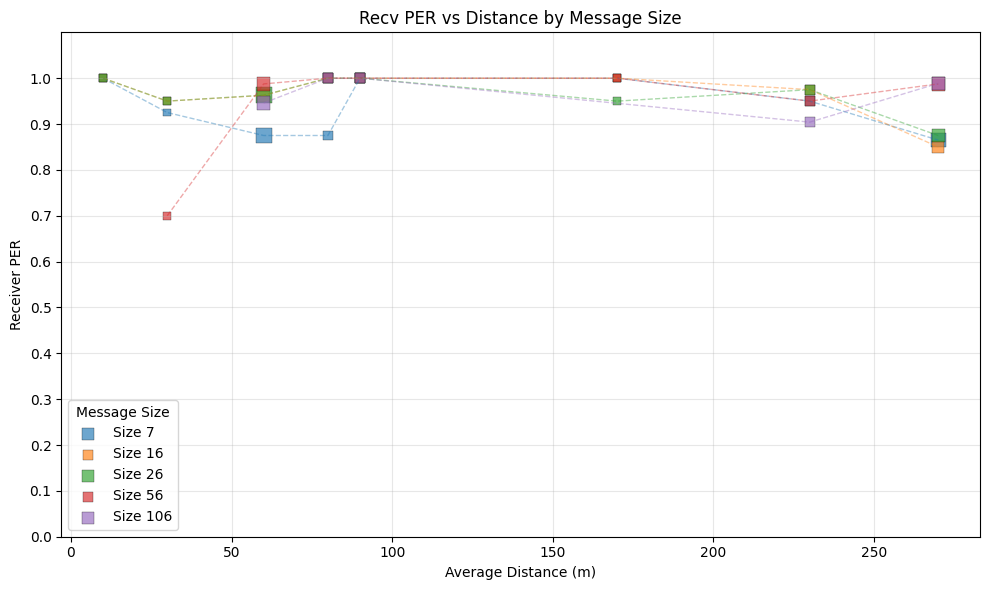

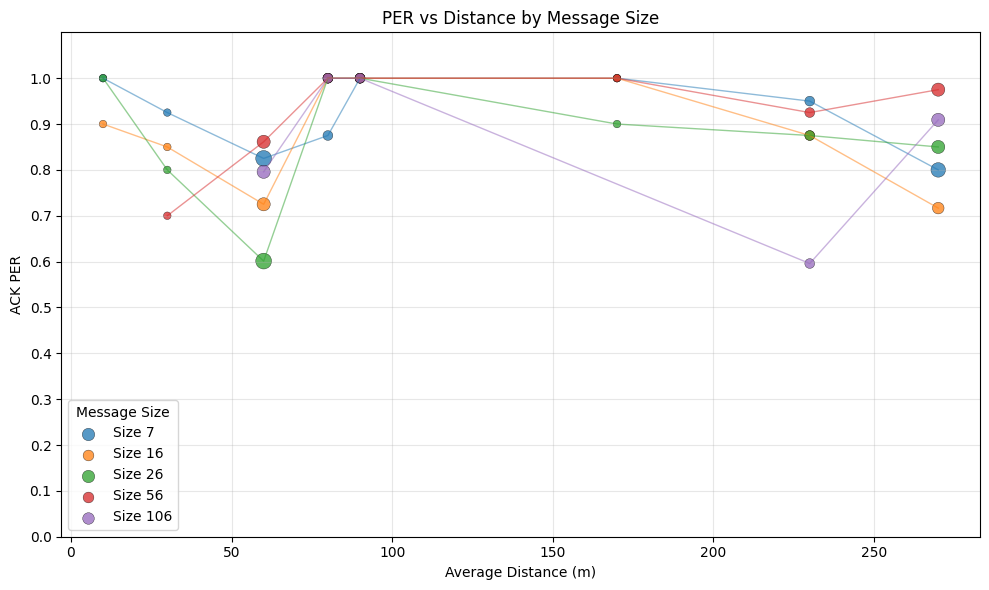

In [27]:
# After processing all sizes, build and plot PER vs Distance
if ack_per_distance_records:
    per_distance_df = pd.DataFrame(ack_per_distance_records)
    agg_dict = {'PER': ('PER', 'mean'), 'Samples': ('PER', 'count')}
    if 'Recv_PER' in per_distance_df.columns:
        agg_dict['Recv_PER'] = ('Recv_PER', 'mean')
    aggregated = (
        per_distance_df
        .groupby(['Msg Size', 'Distance'], as_index=False)
        .agg(**agg_dict)
    )
    aggregated = aggregated.sort_values(['Msg Size', 'Distance'])

    # Additional alternative plot using PER (ACK PER) instead of Recv_PER per request
    plt.figure(figsize=(10, 6))
    for sz, grp in aggregated.groupby('Msg Size'):
        sizes_marker = grp['Samples'].apply(lambda c: 30 + (c - 1) * 20)
        plt.scatter(grp['Distance'], grp['Recv_PER'], s=sizes_marker, marker='s', label=f'Size {sz}', alpha=0.65, edgecolor='k', linewidth=0.3)
        plt.plot(grp['Distance'], grp['Recv_PER'], linewidth=1, alpha=0.4, linestyle='--')
    plt.xlabel('Average Distance (m)')
    plt.ylabel('Receiver PER')
    plt.ylim(0, 1.1)
    plt.yticks(np.arange(0, 1.01, 0.1))
    plt.title('Recv PER vs Distance by Message Size')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Message Size')
    plt.tight_layout()
    plt.savefig('recv_per_distance_plot.png', dpi=150)
    plt.show()

    plt.figure(figsize=(10, 6))
    for sz, grp in aggregated.groupby('Msg Size'):
        # Scale marker size by number of samples (min 30)
        sizes_marker = grp['Samples'].apply(lambda c: 30 + (c - 1) * 20)
        plt.scatter(grp['Distance'], grp['PER'], s=sizes_marker, label=f'Size {sz}', alpha=0.75, edgecolor='k', linewidth=0.3)
        plt.plot(grp['Distance'], grp['PER'], linewidth=1, alpha=0.5)

    plt.xlabel('Average Distance (m)')
    plt.ylabel('ACK PER')
    # plt.ylim(0, 1)
    plt.ylim(0, 1.1)
    plt.yticks(np.arange(0, 1.01, 0.1))  # 0.1 step ticks
    plt.title('PER vs Distance by Message Size')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Message Size')
    plt.tight_layout()
    plt.savefig('ack_per_distance_plot.png', dpi=150)
    plt.show()
else:
    print("No ACK batch data collected; skipping plot generation.")

PER bar plot for message size 7

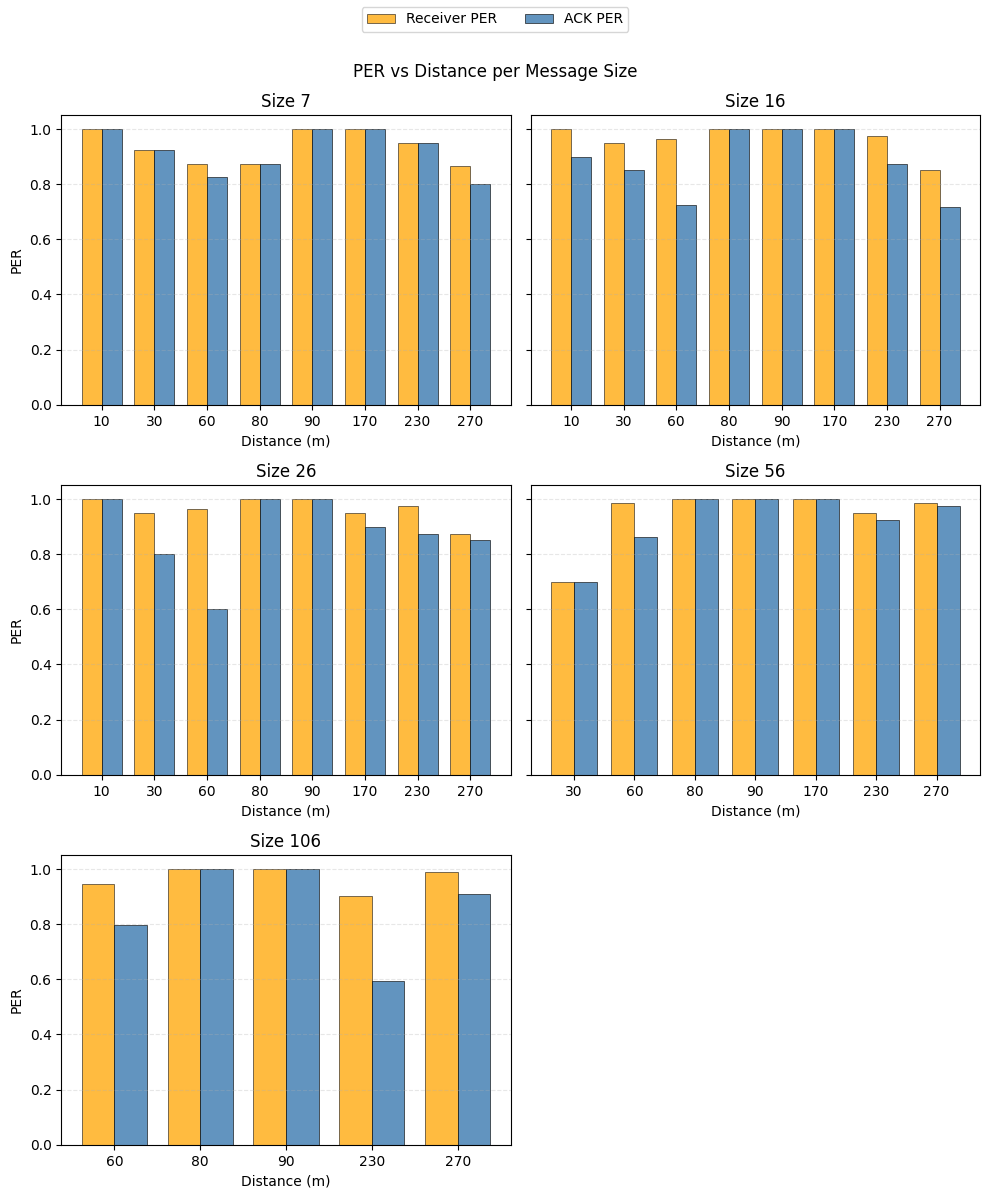

In [28]:
# Bar plots for PER vs Distance for each available message size
if 'ack_per_distance_records' in globals() and ack_per_distance_records:
    agg_available = 'aggregated' in globals() and isinstance(globals().get('aggregated'), pd.DataFrame)
    base_df = globals()['aggregated'].copy() if agg_available else pd.DataFrame(ack_per_distance_records)
    if base_df.empty:
        print('No PER data available to plot.')
    else:
        all_sizes = sorted(base_df['Msg Size'].unique())
        n = len(all_sizes)
        ncols = 2
        nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 4 * nrows), sharey=True)
        axes = np.array(axes).reshape(nrows, ncols)
        global_ylim = 0
        # Pre-compute size dataframes
        size_dfs = {}
        for TARGET_MSG_SIZE in all_sizes:
            if agg_available:
                size_df = base_df[base_df['Msg Size'] == TARGET_MSG_SIZE].copy()
            else:
                per_distance_df = base_df.copy()
                agg_dict = {'PER': ('PER', 'mean'), 'Samples': ('PER', 'count')}
                if 'Recv_PER' in per_distance_df.columns:
                    agg_dict['Recv_PER'] = ('Recv_PER', 'mean')
                size_df = (per_distance_df[per_distance_df['Msg Size'] == TARGET_MSG_SIZE]
                           .groupby(['Msg Size', 'Distance'], as_index=False)
                           .agg(**agg_dict))
            size_df = size_df.sort_values('Distance')
            size_dfs[TARGET_MSG_SIZE] = size_df
            if not size_df.empty:
                global_ylim = max(global_ylim, size_df['PER'].max(), size_df.get('Recv_PER', pd.Series([0])).max())
        # Plot
        for idx, TARGET_MSG_SIZE in enumerate(all_sizes):
            r, c = divmod(idx, ncols)
            ax = axes[r][c]
            size_df = size_dfs[TARGET_MSG_SIZE]
            if size_df.empty:
                ax.text(0.5, 0.5, f'No data for size {TARGET_MSG_SIZE}', ha='center', va='center')
                ax.axis('off')
                continue
            distances = size_df['Distance'].astype(int)
            x = np.arange(len(distances))
            width = 0.38
            ack_vals = size_df['PER']
            recv_vals = size_df['Recv_PER'] if 'Recv_PER' in size_df.columns else None
            if recv_vals is not None:
                ax.bar(x - width/2, recv_vals, width, label='Receiver PER', color='orange', alpha=0.75, edgecolor='k', linewidth=0.5)
                ax.bar(x + width/2, ack_vals, width, label='ACK PER', color='steelblue', alpha=0.85, edgecolor='k', linewidth=0.5)
            else:
                ax.bar(x, ack_vals, width, label='ACK PER', color='steelblue', alpha=0.85, edgecolor='k', linewidth=0.5)
            ax.set_title(f'Size {TARGET_MSG_SIZE}')
            ax.set_xticks(x)
            ax.set_xticklabels(distances, rotation=0)
            ax.set_xlabel('Distance (m)')
            if c == 0:
                ax.set_ylabel('PER')
            ax.grid(axis='y', linestyle='--', alpha=0.3)
        # Hide unused axes
        for j in range(n, nrows * ncols):
            r, c = divmod(j, ncols)
            axes[r][c].axis('off')
        # Unified legend
        handles, labels = [], []
        for ax in axes.flat:
            for h, l in zip(*ax.get_legend_handles_labels()):
                if l not in labels:
                    handles.append(h); labels.append(l)
        if handles:
            fig.legend(handles, labels, loc='upper center', ncol=len(labels))
        ylim_val = max(1.0, global_ylim * 1.05)
        for ax in axes.flat:
            if ax.has_data():
                ax.set_ylim(0, ylim_val)
        fig.suptitle('PER vs Distance per Message Size', y=0.95)
        plt.tight_layout(rect=(0, 0, 1, 0.965))
        plt.savefig('bar_per_distance.png', dpi=150)

        del base_df, size_dfs, size_df
else:
    print('No ACK batch data collected; cannot create bar plots for all sizes.')


Power vs Distance Analysis

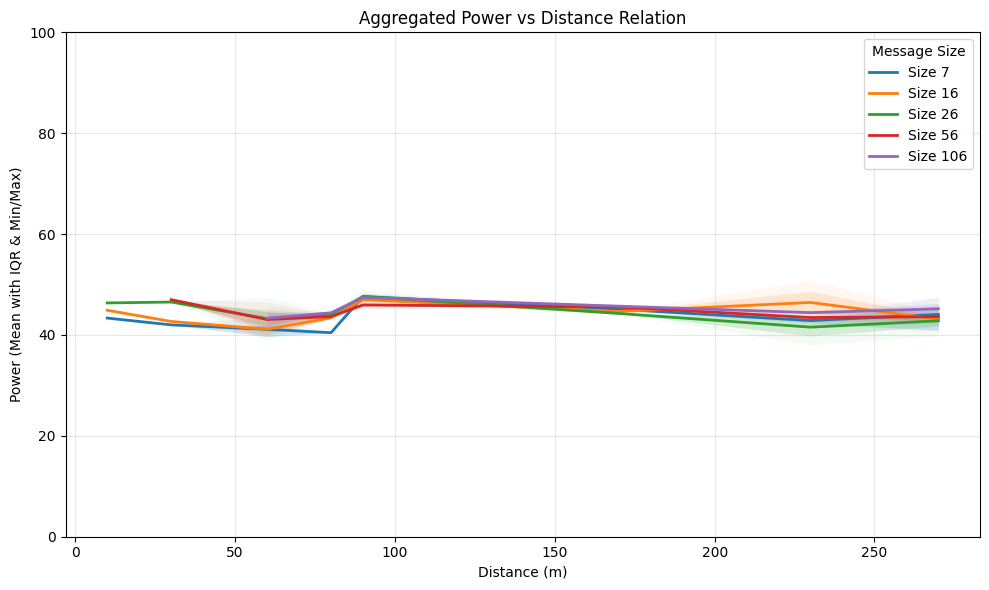

In [29]:
# Reuse ack_per_distance_records to show Power vs Distance relation (not ratio)
cmap = plt.get_cmap('tab10')
if 'ack_per_distance_records' in globals() and ack_per_distance_records:
    power_source_df = pd.DataFrame(ack_per_distance_records).copy()
    # Ensure numeric
    for col in ['Power', 'RSSI', 'Distance']:
        if col in power_source_df.columns:
            power_source_df[col] = pd.to_numeric(power_source_df[col], errors='coerce')
    power_source_df = power_source_df.dropna(subset=['Power', 'Distance'])

    # Aggregate stats per (Msg Size, Distance)
    power_agg = (
        power_source_df
        .groupby(['Msg Size', 'Distance'])
        .agg(
            Samples=('Power', 'count'),
            MeanPower=('Power', 'mean'),
            MedianPower=('Power', 'median'),
            Q1=('Power', lambda s: s.quantile(0.25)),
            Q3=('Power', lambda s: s.quantile(0.75)),
            MinPower=('Power', 'min'),
            MaxPower=('Power', 'max'),
            MeanRSSI=('RSSI', 'mean') if 'RSSI' in power_source_df.columns else ('Power', 'mean')
        )
        .reset_index()
        .sort_values(['Msg Size', 'Distance'])
    )

    # 2) Aggregated mean with IQR shading per size
    plt.figure(figsize=(10, 6))
    for idx, (sz, grp) in enumerate(power_agg.groupby('Msg Size')):
        color = cmap(idx % 10)
        plt.plot(grp['Distance'], grp['MeanPower'], color=color, linewidth=2, label=f'Size {sz}')
        # IQR band
        plt.fill_between(grp['Distance'], grp['Q1'], grp['Q3'], color=color, alpha=0.15, linewidth=0)
        # Min/Max whiskers (optional thin)
        plt.fill_between(grp['Distance'], grp['MinPower'], grp['MaxPower'], color=color, alpha=0.05, linewidth=0)
    plt.xlabel('Distance (m)')
    plt.ylabel('Power (Mean with IQR & Min/Max)')
    plt.title('Aggregated Power vs Distance Relation')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Message Size')
    plt.tight_layout()
    try:
        plt.savefig('power_distance_aggregated.png', dpi=150)
    except Exception as e:
        print('Save failed (power_distance_aggregated):', e)
    plt.show()
else:
    print('ack_per_distance_records not available or empty; skipping Power vs Distance relation plots.')

RSSI vs Distance Analysis

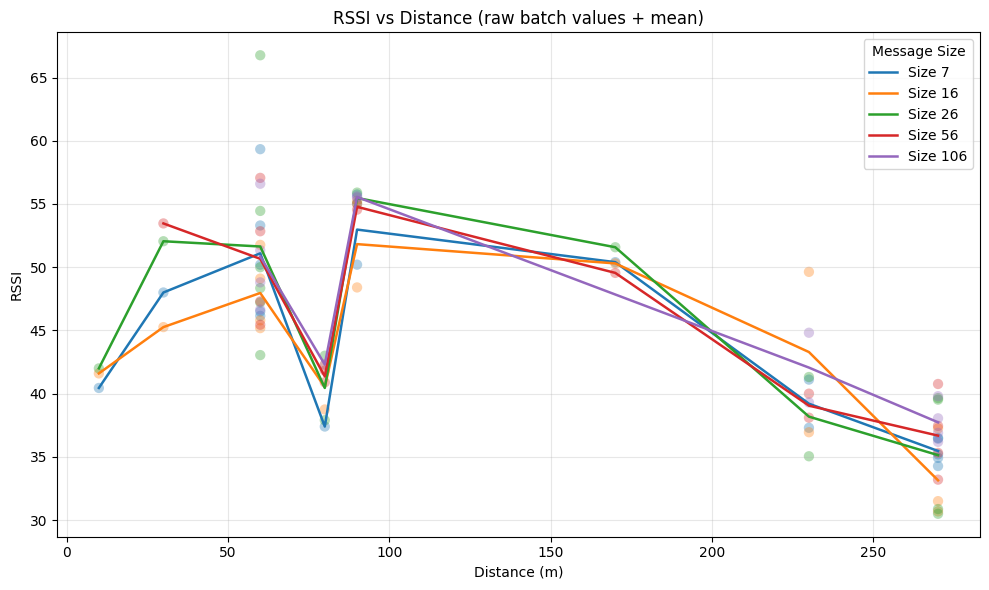

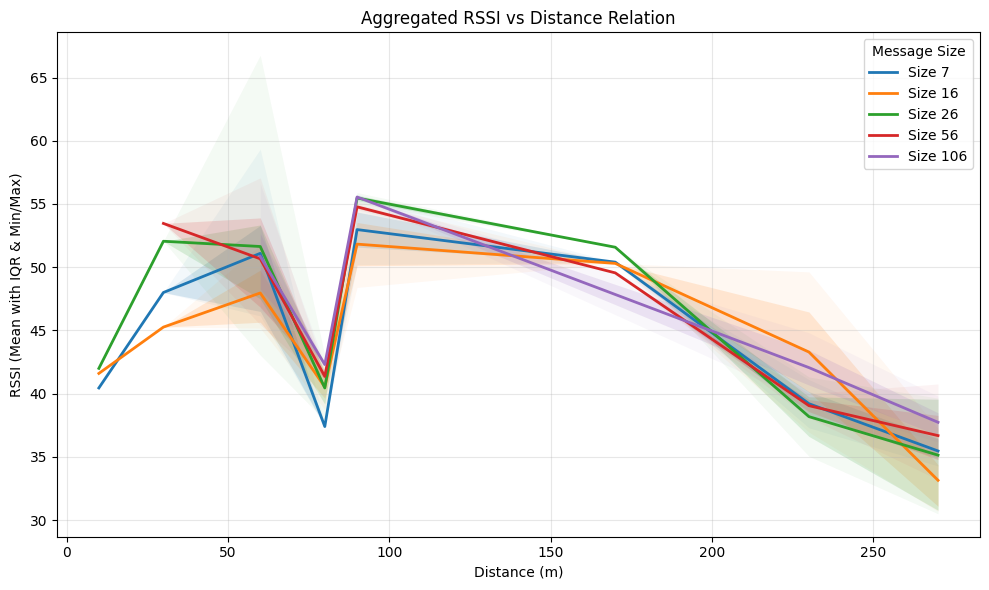

C:\Users\user\AppData\Local\Temp\ipykernel_23912\1191557722.py:95: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[int(d) for d in distances], patch_artist=True, showfliers=False)
C:\Users\user\AppData\Local\Temp\ipykernel_23912\1191557722.py:95: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[int(d) for d in distances], patch_artist=True, showfliers=False)
C:\Users\user\AppData\Local\Temp\ipykernel_23912\1191557722.py:95: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[int(d) for d in distances], patch_artist=True, showfliers=False)
C

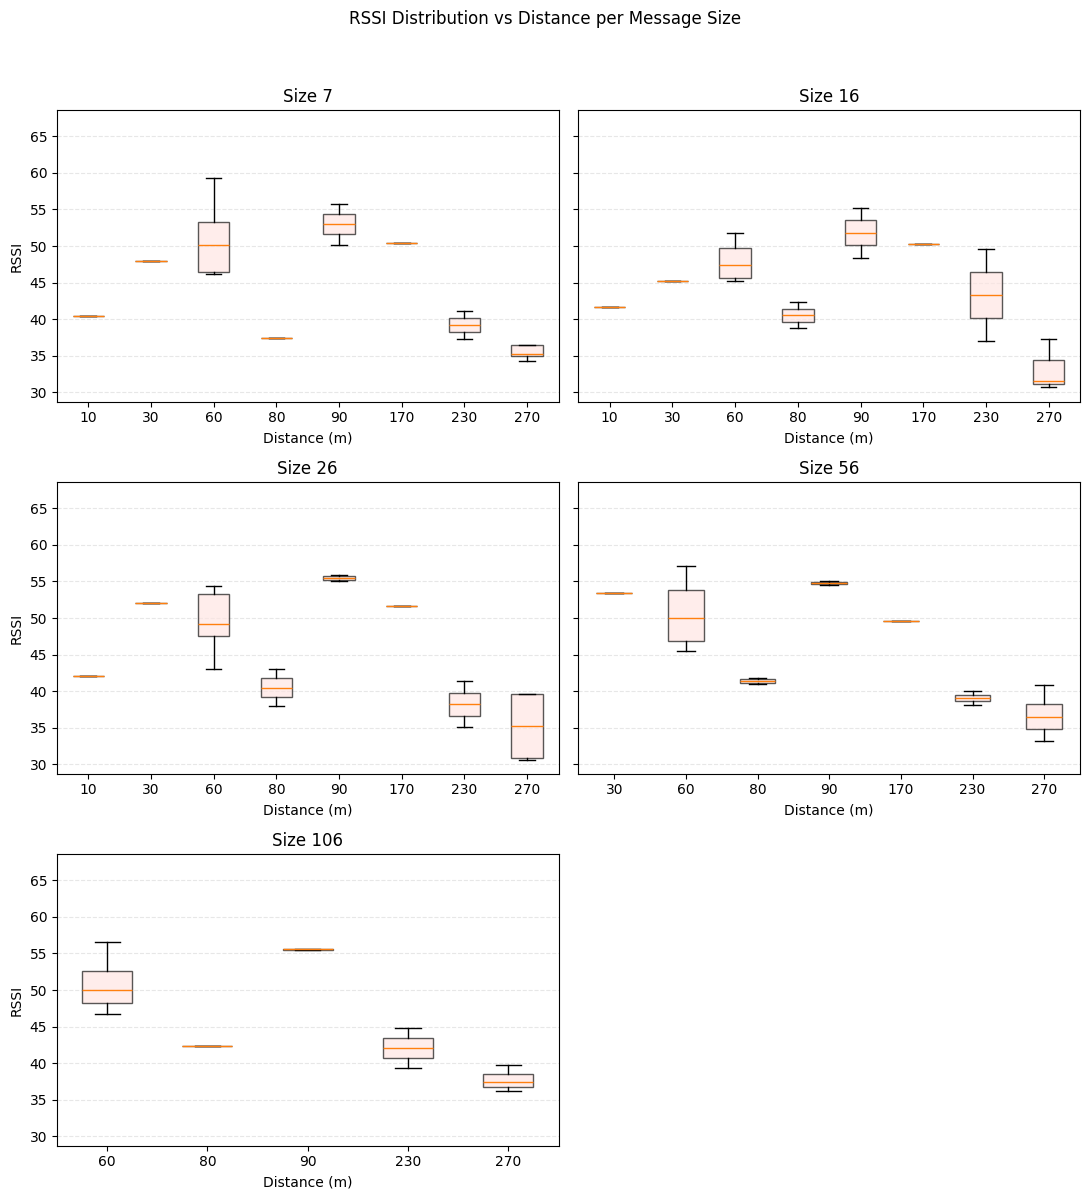

In [30]:
# Reuse ack_per_distance_records to show RSSI vs Distance relation
if 'ack_per_distance_records' in globals() and ack_per_distance_records:
    rssi_source_df = pd.DataFrame(ack_per_distance_records).copy()
    if 'RSSI' not in rssi_source_df.columns:
        print('RSSI field not present in ack_per_distance_records; skipping RSSI plots.')
    else:
        # Ensure numeric
        for col in ['RSSI', 'Distance']:
            rssi_source_df[col] = pd.to_numeric(rssi_source_df[col], errors='coerce')
        rssi_source_df = rssi_source_df.dropna(subset=['RSSI', 'Distance'])
        if rssi_source_df.empty:
            print('No RSSI data after cleaning; skipping RSSI plots.')
        else:
            rssi_agg = (
                rssi_source_df
                .groupby(['Msg Size', 'Distance'])
                .agg(
                    Samples=('RSSI', 'count'),
                    MeanRSSI=('RSSI', 'mean'),
                    MedianRSSI=('RSSI', 'median'),
                    Q1=('RSSI', lambda s: s.quantile(0.25)),
                    Q3=('RSSI', lambda s: s.quantile(0.75)),
                    MinRSSI=('RSSI', 'min'),
                    MaxRSSI=('RSSI', 'max')
                )
                .reset_index()
                .sort_values(['Msg Size', 'Distance'])
            )
            # Determine y-limits with small padding
            rssi_min = rssi_source_df['RSSI'].min()
            rssi_max = rssi_source_df['RSSI'].max()
            y_pad = max(1, (rssi_max - rssi_min) * 0.05)
            y_lower = rssi_min - y_pad
            y_upper = rssi_max + y_pad

            # 1) Scatter of RSSI raw batches + mean line
            plt.figure(figsize=(10, 6))
            cmap = plt.get_cmap('tab10')
            for idx, (sz, raw_grp) in enumerate(rssi_source_df.groupby('Msg Size')):
                color = cmap(idx % 10)
                plt.scatter(raw_grp['Distance'], raw_grp['RSSI'], s=55, alpha=0.35, color=color, edgecolor='none', label=f'Size {sz} raw')
                agg_grp = rssi_agg[rssi_agg['Msg Size'] == sz]
                plt.plot(agg_grp['Distance'], agg_grp['MeanRSSI'], color=color, linewidth=1.8, label=f'Size {sz} mean')
            plt.xlabel('Distance (m)')
            plt.ylabel('RSSI')
            plt.title('RSSI vs Distance (raw batch values + mean)')
            plt.ylim(y_lower, y_upper)
            plt.grid(True, alpha=0.3)
            handles, labels = plt.gca().get_legend_handles_labels()
            filtered = [(h, l) for h, l in zip(handles, labels) if l.endswith('mean')]
            if filtered:
                fh, fl = zip(*filtered)
                plt.legend(fh, [l.replace(' mean', '') for l in fl], title='Message Size')
            plt.tight_layout()
            try:
                plt.savefig('rssi_distance_scatter_mean.png', dpi=150)
            except Exception as e:
                print('Save failed (rssi_distance_scatter_mean):', e)
            plt.show()

            # 2) Aggregated mean with IQR + min/max shading
            plt.figure(figsize=(10, 6))
            for idx, (sz, grp) in enumerate(rssi_agg.groupby('Msg Size')):
                color = cmap(idx % 10)
                plt.plot(grp['Distance'], grp['MeanRSSI'], color=color, linewidth=2, label=f'Size {sz}')
                plt.fill_between(grp['Distance'], grp['Q1'], grp['Q3'], color=color, alpha=0.15, linewidth=0)
                plt.fill_between(grp['Distance'], grp['MinRSSI'], grp['MaxRSSI'], color=color, alpha=0.05, linewidth=0)
            plt.xlabel('Distance (m)')
            plt.ylabel('RSSI (Mean with IQR & Min/Max)')
            plt.title('Aggregated RSSI vs Distance Relation')
            plt.ylim(y_lower, y_upper)
            plt.grid(True, alpha=0.3)
            plt.legend(title='Message Size')
            plt.tight_layout()
            try:
                plt.savefig('rssi_distance_aggregated.png', dpi=150)
            except Exception as e:
                print('Save failed (rssi_distance_aggregated):', e)
            plt.show()

            # 3) Boxplots per size
            sizes_sorted = sorted(rssi_source_df['Msg Size'].unique())
            n = len(sizes_sorted)
            ncols = 2
            nrows = (n + ncols - 1) // ncols
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 4 * nrows), sharey=True)
            axes = np.array(axes).reshape(nrows, ncols)
            for idx, sz in enumerate(sizes_sorted):
                r, c = divmod(idx, ncols)
                ax = axes[r][c]
                sz_df = rssi_source_df[rssi_source_df['Msg Size'] == sz]
                distances = sorted(sz_df['Distance'].unique())
                data = [sz_df[sz_df['Distance'] == d]['RSSI'].values for d in distances]
                if data:
                    bp = ax.boxplot(data, labels=[int(d) for d in distances], patch_artist=True, showfliers=False)
                    for patch in bp['boxes']:
                        patch.set(facecolor='mistyrose', alpha=0.65)
                ax.set_title(f'Size {sz}')
                if c == 0:
                    ax.set_ylabel('RSSI')
                ax.set_xlabel('Distance (m)')
                ax.set_ylim(y_lower, y_upper)
                ax.grid(axis='y', linestyle='--', alpha=0.3)
            for j in range(n, nrows * ncols):
                r, c = divmod(j, ncols)
                axes[r][c].axis('off')
            fig.suptitle('RSSI Distribution vs Distance per Message Size', y=0.995)
            plt.tight_layout(rect=(0, 0, 1, 0.97))
            try:
                plt.savefig('rssi_distance_boxplots.png', dpi=150)
            except Exception as e:
                print('Save failed (rssi_distance_boxplots):', e)
            plt.show()
else:
    print('ack_per_distance_records not available or empty; skipping RSSI vs Distance relation plots.')